# Illustration of datascience Tables on Open Data from Berkeley

**David E. Culler**

Datascience Table provides a simple, yet powerful data structure for a range of analyses.  The basic concept is an ordered set of named columns.  

* It builds on the intuition many develop with *excel* - data is represented as rectangular regions.  But, rather than labeling cells, the column labels really mean something. 
* Tables embed smoothly in jupyter notebooks, so the user experience is that of a computational document, rather than a spreadsheet. This provides a much clearer sequence of steps from raw data to finished product, at least if they are well constructed.  There is no need to break out into *visual basic* or the like when you need more than the basics.
* Tables draws heavily from relational database tables, but there is no separate language (e.g., SQL) required to do relational operations in them.
* Tables provide also the concepts associated with *pivot tables* in Excel, which are closely related to relational operations, but often more natural.
* Tables can be viewed as simple variants of the *dataframes* in **R** or *Pandas*.  The key is simplicity.  They are simple rectangular structures.  The cells of a table can hold arbitrary values, although columns are homogeneous, so the additional power (and complexity) of higher dimensions are rarely needed.
* Tables builds directly on the scipy ecosystem.  Almost any sequence can go in, `numpy.array`s come out.  Thus, it is natural to manipulate data directly from Tables. Basic visualization is provide directly in terms of Tables, so you can go a long ways before reading `matplotlib` documentation.  However, if you need more, a lot of it can be gained through `keyword args` - and if that is not enough, drop into scipy.

This notebook illustrates some of the use of Tables using municipal salary data made possible though the City of Berkeley's open data portal.

In [1]:
# This useful nonsense just goes at the top
from datascience import *
import numpy as np
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline
# datascience version number of last run of this notebook
version.__version__

'0.5.4'

## Reading raw data into a Table

Let's pull a big wad of City Employee salary data from the Berkeley Open Data portal.  

Since this was a trial till June 30, 2015 and you have to mouse around to get csv files, we happen to have pulled a local copy.

In [2]:
raw_berkeley_sal_2011 = Table.read_table("./data/BerkeleyData/City_of_Berkeley_Employee_Salaries_-_2011.csv")

Let's take a peek at what we have got.

In [3]:
# Tables are rendered to work in a notebook, even if they are large.  Only part shows.
# You can adjust how much of it you see, but here we'd have ~1500 rows!
raw_berkeley_sal_2011

Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Total Benefits,Total Pay,Total Pay Benefits
HOWARD H NONOGUCHI,POLICE SERGEANT,$132540.85,$114387.97,$53483.56,$102377.48,$300412.38,$402789.86
DAVID A FRANKEL,POLICE LIEUTENANT,$159094.73,$38995.01,$41465.57,$124819.29,$239555.31,$364374.60
MICHAEL K MEEHAN,POLICE CHIEF,$205400.00,$0.00,$7380.00,$124814.56,$212780.00,$337594.56
ERIK M UPSON,POLICE CAPTAIN,$182382.48,$0.00,$19346.55,$133848.06,$201729.03,$335577.09
KEVIN M SCHOFIELD,POLICE LIEUTENANT,$159094.73,$31284.18,$20132.52,$119134.15,$210511.43,$329645.58
CYNTHIA HARRIS,POLICE CAPTAIN,$182382.48,$0.00,$21884.00,$121365.25,$204266.48,$325631.73
ANDREW R GREENWOOD,POLICE CAPTAIN,$159094.73,$7668.11,$34550.65,$123852.11,$201313.49,$325165.60
RANDOLPH FILES,POLICE LIEUTENANT,$159094.73,$28364.65,$19671.10,$117449.09,$207130.48,$324579.57
EDWARD A SPILLER,POLICE LIEUTENANT,$134457.24,$36225.22,$38738.16,$111729.65,$209420.62,$321150.27
JOHN R TARASCIO,FIRE LIEUTENANT,$117198.12,$87476.09,$27504.05,$82069.44,$232178.26,$314247.70


## Accessing data in a Table

A column of Table data is accessed by indexing it by name.  This returns the column as a numpy array.

In [4]:
raw_berkeley_sal_2011['Base Pay']

array(['$132540.85', '$159094.73', '$205400.00', ..., '$0.00', '$0.00',
       '$0.00'], dtype=object)

Some prefer the selectors - column and row

In [5]:
raw_berkeley_sal_2011.column('Overtime Pay')

array(['$114387.97', '$38995.01', '$0.00', ..., '$0.00', '$0.00', '$0.00'], dtype=object)

Rows in the table can be indexed and sliced.  A row is a little like a record or dict.  It is an tupled, ordered according to the table it comes from and keeping the column names.  

In [6]:
raw_berkeley_sal_2011.rows[0]

Row(Employee Name='HOWARD H NONOGUCHI', Job Title='POLICE SERGEANT', Base Pay='$132540.85', Overtime Pay='$114387.97', Other Pay='$53483.56', Total Benefits='$102377.48', Total Pay='$300412.38', Total Pay Benefits='$402789.86')

In [7]:
raw_berkeley_sal_2011.row(0).item('Base Pay')

'$132540.85'

In [8]:
raw_berkeley_sal_2011.row(0)[2]

'$132540.85'

In [9]:
raw_berkeley_sal_2011.row(0).asdict()

OrderedDict([('Employee Name', 'HOWARD H NONOGUCHI'),
             ('Job Title', 'POLICE SERGEANT'),
             ('Base Pay', '$132540.85'),
             ('Overtime Pay', '$114387.97'),
             ('Other Pay', '$53483.56'),
             ('Total Benefits', '$102377.48'),
             ('Total Pay', '$300412.38'),
             ('Total Pay Benefits', '$402789.86')])

In [10]:
raw_berkeley_sal_2011.rows[0:10]

<generator object Table.Rows.__getitem__.<locals>.<genexpr> at 0x10fa86ba0>

## Converting data in a Table to make it workable

When we read in data from a csv file we got a bunch of columns filled with a bunch of strings.  As is often the case, we want the data in a column to represent values that we can analyze, whereas we want the printed format of a column to reflect its meaning.  Currency is the most common such situation.  Let's clean up our salary table.

We might start by getting ahold of the names of column that we want to clean up

In [11]:
paylabels = raw_berkeley_sal_2011.labels[2:]
paylabels

('Base Pay',
 'Overtime Pay',
 'Other Pay',
 'Total Benefits',
 'Total Pay',
 'Total Pay Benefits')

### Clean derivatives of raw tables

It is good hygene to keep the raw data raw and produce distinct, clean derivatives.  Let's start by making a copy of the raw table.  A new name and a new table.

In [12]:
berkeley_sal_2011 = raw_berkeley_sal_2011.copy()

### Tables allow columns to have customized formatters

In Excel you do this by formatting the cells.  We want to have the data as numbers, keep track of the type, and have it look nice.

In [13]:
berkeley_sal_2011.set_format(paylabels, CurrencyFormatter)
berkeley_sal_2011

Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Total Benefits,Total Pay,Total Pay Benefits
HOWARD H NONOGUCHI,POLICE SERGEANT,"$132,540.85","$114,387.97","$53,483.56","$102,377.48","$300,412.38","$402,789.86"
DAVID A FRANKEL,POLICE LIEUTENANT,"$159,094.73","$38,995.01","$41,465.57","$124,819.29","$239,555.31","$364,374.60"
MICHAEL K MEEHAN,POLICE CHIEF,"$205,400.00",$0.00,"$7,380.00","$124,814.56","$212,780.00","$337,594.56"
ERIK M UPSON,POLICE CAPTAIN,"$182,382.48",$0.00,"$19,346.55","$133,848.06","$201,729.03","$335,577.09"
KEVIN M SCHOFIELD,POLICE LIEUTENANT,"$159,094.73","$31,284.18","$20,132.52","$119,134.15","$210,511.43","$329,645.58"
CYNTHIA HARRIS,POLICE CAPTAIN,"$182,382.48",$0.00,"$21,884.00","$121,365.25","$204,266.48","$325,631.73"
ANDREW R GREENWOOD,POLICE CAPTAIN,"$159,094.73","$7,668.11","$34,550.65","$123,852.11","$201,313.49","$325,165.60"
RANDOLPH FILES,POLICE LIEUTENANT,"$159,094.73","$28,364.65","$19,671.10","$117,449.09","$207,130.48","$324,579.57"
EDWARD A SPILLER,POLICE LIEUTENANT,"$134,457.24","$36,225.22","$38,738.16","$111,729.65","$209,420.62","$321,150.27"
JOHN R TARASCIO,FIRE LIEUTENANT,"$117,198.12","$87,476.09","$27,504.05","$82,069.44","$232,178.26","$314,247.70"


Now we get values we can compute on - and they still display as currency.

In [14]:
berkeley_sal_2011['Base Pay']

array([ 132540.85,  159094.73,  205400.  , ...,       0.  ,       0.  ,
             0.  ])

In [15]:
max(berkeley_sal_2011['Total Pay Benefits'])

402789.85999999999

## Descriptive Statistics Summary

Now we can try to get a summary of the data with some descriptive statistics.  

The `stats` method on Tables computes a list of statistics over each column and creates a new Table containing these statistics.  The default is tailored to the Berkeley Data8 course. Here we provide what you expect from the `summary` operation in **R**

In [16]:
def firstQtile(x) : return np.percentile(x,25)
def thirdQtile(x) : return np.percentile(x,25)
summary_ops = (min, firstQtile, np.median, np.mean, thirdQtile, max)

In [17]:
berkeley_sal_2011.select(paylabels).stats(ops=summary_ops)

statistic,Base Pay,Overtime Pay,Other Pay,Total Benefits,Total Pay,Total Pay Benefits
min,0,0,-94730.8,0,0,0
firstQtile,57674,0,0,36846.6,61125.3,99726.7
median,72988.3,0,1285.45,48490.3,79118.4,128068
mean,76909.1,5619.79,3365.87,49509.6,85894.8,135404
thirdQtile,57674,0,0,36846.6,61125.3,99726.7
max,205400,114388,64036.7,133848,300412,402790


OK, so it looks like the average salary is about 86k, and it ranges up to 300k with some hefty overtime pay.  Let's see if we can understand what is going on.

## Visualizing data

* `Table.select` creates a new table consisting of the specified list of columns.
* `Table.hist` plots a histogram of each of the columns in a table.  It can either overlay the histograms or show them separately.  Here we have specified the number of bins

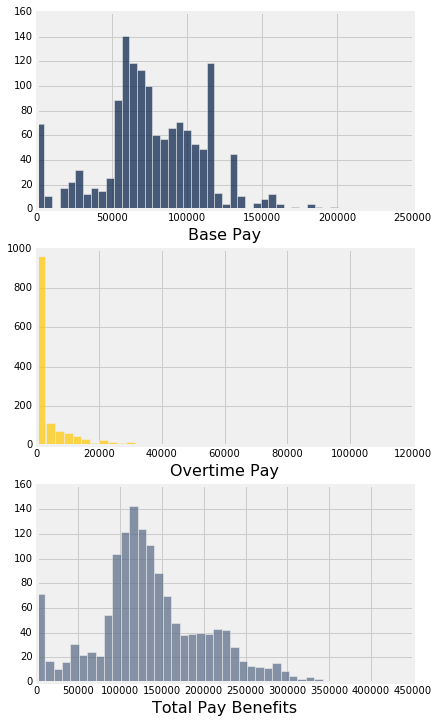

In [18]:
berkeley_sal_2011.select(["Base Pay", 
                          "Overtime Pay", 
                          "Total Pay Benefits"]).hist(overlay=False,normed=False,
                                                      bins=40)

Interesting.  Base pay is bimodal.  Most employees get no overtime, but there is a looong tale.  Let's look at the individual level.  Who's at the top?

In [19]:
berkeley_sal_2011.sort('Total Pay Benefits', descending=True)

Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Total Benefits,Total Pay,Total Pay Benefits
HOWARD H NONOGUCHI,POLICE SERGEANT,"$132,540.85","$114,387.97","$53,483.56","$102,377.48","$300,412.38","$402,789.86"
DAVID A FRANKEL,POLICE LIEUTENANT,"$159,094.73","$38,995.01","$41,465.57","$124,819.29","$239,555.31","$364,374.60"
MICHAEL K MEEHAN,POLICE CHIEF,"$205,400.00",$0.00,"$7,380.00","$124,814.56","$212,780.00","$337,594.56"
ERIK M UPSON,POLICE CAPTAIN,"$182,382.48",$0.00,"$19,346.55","$133,848.06","$201,729.03","$335,577.09"
KEVIN M SCHOFIELD,POLICE LIEUTENANT,"$159,094.73","$31,284.18","$20,132.52","$119,134.15","$210,511.43","$329,645.58"
CYNTHIA HARRIS,POLICE CAPTAIN,"$182,382.48",$0.00,"$21,884.00","$121,365.25","$204,266.48","$325,631.73"
ANDREW R GREENWOOD,POLICE CAPTAIN,"$159,094.73","$7,668.11","$34,550.65","$123,852.11","$201,313.49","$325,165.60"
RANDOLPH FILES,POLICE LIEUTENANT,"$159,094.73","$28,364.65","$19,671.10","$117,449.09","$207,130.48","$324,579.57"
EDWARD A SPILLER,POLICE LIEUTENANT,"$134,457.24","$36,225.22","$38,738.16","$111,729.65","$209,420.62","$321,150.27"
JOHN R TARASCIO,FIRE LIEUTENANT,"$117,198.12","$87,476.09","$27,504.05","$82,069.44","$232,178.26","$314,247.70"


So where does the $alary go? First, how many employees?

`Table.num_rows` returns just what you'd think. The number of rows.  Which in this case is the number of employees on the city payroll.

In [20]:
berkeley_sal_2011.num_rows

1437

## Grouping and Sorting Table data

* `Table.drop` creates a new Table without some columns.  It is like select, but you don't have to name everythng you want.
* `Table.group` aggregates data by grouping all the rows that contain a common value in one (or more) columns.  Here we group in "Job Title" summing the entries in all other columns for each group.  We placed a column full of `1` to get a count, while summing salaries and such.
* `Table.sort` sorts the rows in a Table by a column - just like sort in Excel.

In [21]:
# lose the individual names
job_titles = berkeley_sal_2011.drop("Employee Name") 
# Build a handy column full of 1s
job_titles["Title"] = 1
# Group by title summing the number of rows per
by_title = job_titles.group("Job Title", sum)  
# Sort by the number of employees per title
ordered_by_title = by_title.sort('Title sum', descending = True) 
# let's see what we get
ordered_by_title 

Job Title,Base Pay sum,Overtime Pay sum,Other Pay sum,Total Benefits sum,Total Pay sum,Total Pay Benefits sum,Title sum
POLICE OFFICER,1.26079e+07,1.66885e+06,1.22694e+06,9.36767e+06,1.55037e+07,2.48713e+07,131
OFFICE SPECIALIST II,3.09984e+06,4202.74,-213202,1.88603e+06,2.89084e+06,4.77687e+06,56
FIREFIGHTER,3.53733e+06,593383,670533,2.38227e+06,4.80125e+06,7.18351e+06,54
SOLID WASTE WORKER,2.07557e+06,422455,-5278.96,1.66431e+06,2.49275e+06,4.15706e+06,36
FIRE APPARATUS OPERATOR,3.80306e+06,541058,757143,2.56267e+06,5.10126e+06,7.66393e+06,36
POLICE SERGEANT,4.29433e+06,796218,596785,3.21102e+06,5.68734e+06,8.89836e+06,33
SOLID WASTE TRUCK DRIVER,2.1416e+06,338808,63332.1,1.76164e+06,2.54374e+06,4.30539e+06,32
OFFICE SPECIALIST III,1.95138e+06,23228.8,31125.6,1.12598e+06,2.00574e+06,3.13172e+06,30
PUBLIC SAFETY DISPATCHER II,1.83488e+06,455170,134222,1.04205e+06,2.42427e+06,3.46632e+06,26
PARKING ENFORCEMENT OFFICER,1.48252e+06,201141,39177.2,1.02214e+06,1.72283e+06,2.74498e+06,26


In [22]:
ordered_by_title.num_rows

305

Wow, 305 Job Titles for 1437 employees!

In [23]:
"{0:.3} employees per Job Code".format(berkeley_sal_2011.num_rows/ordered_by_title.num_rows)

'4.71 employees per Job Code'

## Plotting data

* `Table.plot` plots each of the columns in a table, either on separate charts or overlayed on a single chart.  Optionally one of the columns can be specified as the horizontal axis and all others plotted against this.

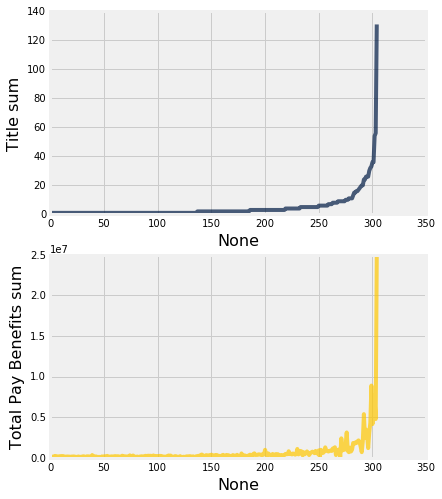

In [24]:
ordered_by_title.select(['Title sum','Total Pay Benefits sum']).sort('Title sum').plot(overlay=False)

How about that, a few job categories have most of the employes and most of the spend, but it is far from uniform.  Let's look a little deeper.  Which categories consume most of the budget?

In [25]:
by_title.sort('Total Pay Benefits sum', descending = True)

Job Title,Base Pay sum,Overtime Pay sum,Other Pay sum,Total Benefits sum,Total Pay sum,Total Pay Benefits sum,Title sum
POLICE OFFICER,1.26079e+07,1.66885e+06,1.22694e+06,9.36767e+06,1.55037e+07,2.48713e+07,131
POLICE SERGEANT,4.29433e+06,796218,596785,3.21102e+06,5.68734e+06,8.89836e+06,33
FIRE APPARATUS OPERATOR,3.80306e+06,541058,757143,2.56267e+06,5.10126e+06,7.66393e+06,36
FIREFIGHTER,3.53733e+06,593383,670533,2.38227e+06,4.80125e+06,7.18351e+06,54
FIRE LIEUTENANT,2.71831e+06,502590,439075,1.72013e+06,3.65997e+06,5.3801e+06,24
OFFICE SPECIALIST II,3.09984e+06,4202.74,-213202,1.88603e+06,2.89084e+06,4.77687e+06,56
SOLID WASTE TRUCK DRIVER,2.1416e+06,338808,63332.1,1.76164e+06,2.54374e+06,4.30539e+06,32
SOLID WASTE WORKER,2.07557e+06,422455,-5278.96,1.66431e+06,2.49275e+06,4.15706e+06,36
PUBLIC SAFETY DISPATCHER II,1.83488e+06,455170,134222,1.04205e+06,2.42427e+06,3.46632e+06,26
OFFICE SPECIALIST III,1.95138e+06,23228.8,31125.6,1.12598e+06,2.00574e+06,3.13172e+06,30


In [26]:
by_title.sort('Total Pay Benefits sum', descending = True).row(0)

Row(Job Title='POLICE OFFICER', Base Pay sum=12607875.889999993, Overtime Pay sum=1668851.7199999997, Other Pay sum=1226939.47, Total Benefits sum=9367668.2600000016, Total Pay sum=15503667.079999996, Total Pay Benefits sum=24871335.339999992, Title sum=131)

In [27]:
by_title.select(('Job Title', 'Total Pay Benefits sum')).sort('Total Pay Benefits sum', descending=True)

Job Title,Total Pay Benefits sum
POLICE OFFICER,2.48713e+07
POLICE SERGEANT,8.89836e+06
FIRE APPARATUS OPERATOR,7.66393e+06
FIREFIGHTER,7.18351e+06
FIRE LIEUTENANT,5.3801e+06
OFFICE SPECIALIST II,4.77687e+06
SOLID WASTE TRUCK DRIVER,4.30539e+06
SOLID WASTE WORKER,4.15706e+06
PUBLIC SAFETY DISPATCHER II,3.46632e+06
OFFICE SPECIALIST III,3.13172e+06


As is often the case in the real world, the categorization used for operations is not directly useful for analysis.  We often need to build categories in order to get a handle on what's going on.

What do all those job titles look like

In [28]:
ordered_by_title['Job Title']

array(['POLICE OFFICER', 'OFFICE SPECIALIST II', 'FIREFIGHTER',
       'SOLID WASTE WORKER', 'FIRE APPARATUS OPERATOR', 'POLICE SERGEANT',
       'SOLID WASTE TRUCK DRIVER', 'OFFICE SPECIALIST III',
       'PUBLIC SAFETY DISPATCHER II', 'PARKING ENFORCEMENT OFFICER',
       'LIBRARY ASSISTANT', 'FIRE LIEUTENANT', 'ACCOUNTING OFF SPEC III',
       'LIBRARY AIDE', 'LIBRARIAN II', 'LIBRARY SPECIALIST II', 'LABORER',
       'ASSOCIATE MANAGEMENT ANALYST', 'SKILLED LABORER',
       'BUILDING MAINTENANCE MECHANIC', 'LANDSCAPE GARDENER',
       'COMMUNITY SERVICE OFFICER', 'PUBLIC HEALTH NURSE',
       'RECREATION ACTIVITY LEADER', 'PSYCH SOC WKR II',
       'LEGISLATIVE ASSISTANT', 'COMMUNITY HLTH WRKR SPECIALIST',
       'SENIOR MANAGEMENT ANALYST', 'POLICE LIEUTENANT',
       'COMMUNITY SERVS SP I', 'SUPERVISING LIBRARY ASSISTANT',
       'SUPERVISING LIBRARIAN', 'RENT BOARD COMMISSIONER', 'FIRE CAPTAIN',
       'CUST SERVS SPEC III', 'APPLICATIONS PROG/ANA II',
       'ADMINISTRATIVE SECR

In [29]:
categories = {
    'Police': ["POLICE"], 
    'Fire': ["FIRE"], 
    'Animal Control':["ANIMAL"], 
    'Health': ["HEALTH", "PSYCH", "HLTH"],
    'Library': ['LIBRARY','LIBRARIAN'],
    'Offical' : ['MAYOR','COUNCIL', 'COMMISSIONER', 'CITY MANAGER'],
    'Trades' :["ELECTRICIAN","MECHANIC", "ENGINEER"],
    'Parking' : ["PARKING"],
    'Recreation' : ["RECREATION", "AQUATICS"],
    'Gardener' : ["GARDEN"],
    "Labor" : ["LABOR", "JANITOR"],
    'Community': ["COMMUNITY"],
    'Admin' : ["ADMIN"],
    'Traffic' : ["TRAFFIC"],
    'Accounting' : ["ACCOUNT"],
    'Dispatch' : ["DISPATCH"],
    'Waste' : ["WASTE", "SEWER"],
    'Analyst' : ["ANALYS"],
    'Office' : ["OFFICE "],
    'Legal' : ['LEGISLAT', 'ATTORN', 'ATTY'],
    'IT' : ["PROG", "INFORMATION SYSTEMS"],
    'School' : ["SCHOOL"],
    'Architect' : ["ARCHITECT"],
    'Planner' : ["PLANNER", "PERMIT"]
    }

In [30]:
categories

{'Accounting': ['ACCOUNT'],
 'Admin': ['ADMIN'],
 'Analyst': ['ANALYS'],
 'Animal Control': ['ANIMAL'],
 'Architect': ['ARCHITECT'],
 'Community': ['COMMUNITY'],
 'Dispatch': ['DISPATCH'],
 'Fire': ['FIRE'],
 'Gardener': ['GARDEN'],
 'Health': ['HEALTH', 'PSYCH', 'HLTH'],
 'IT': ['PROG', 'INFORMATION SYSTEMS'],
 'Labor': ['LABOR', 'JANITOR'],
 'Legal': ['LEGISLAT', 'ATTORN', 'ATTY'],
 'Library': ['LIBRARY', 'LIBRARIAN'],
 'Offical': ['MAYOR', 'COUNCIL', 'COMMISSIONER', 'CITY MANAGER'],
 'Office': ['OFFICE '],
 'Parking': ['PARKING'],
 'Planner': ['PLANNER', 'PERMIT'],
 'Police': ['POLICE'],
 'Recreation': ['RECREATION', 'AQUATICS'],
 'School': ['SCHOOL'],
 'Trades': ['ELECTRICIAN', 'MECHANIC', 'ENGINEER'],
 'Traffic': ['TRAFFIC'],
 'Waste': ['WASTE', 'SEWER']}

## Applying a function to create a new column

* `table.apply`: applies a function to every element in a column.  

One of the best examples of high-order functions and tables is in categorizing data. As is often the case, we create a new column with the results

In [31]:
def categorize (title) : 
    for category, keywords in categories.items():
        for word in keywords :
            if title.find(word) >= 0 : return category
    return 'Other'

In [32]:
berkeley_sal_2011['Category'] = berkeley_sal_2011.apply(categorize, 'Job Title')
berkeley_sal_2011

Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Total Benefits,Total Pay,Total Pay Benefits,Category
HOWARD H NONOGUCHI,POLICE SERGEANT,"$132,540.85","$114,387.97","$53,483.56","$102,377.48","$300,412.38","$402,789.86",Police
DAVID A FRANKEL,POLICE LIEUTENANT,"$159,094.73","$38,995.01","$41,465.57","$124,819.29","$239,555.31","$364,374.60",Police
MICHAEL K MEEHAN,POLICE CHIEF,"$205,400.00",$0.00,"$7,380.00","$124,814.56","$212,780.00","$337,594.56",Police
ERIK M UPSON,POLICE CAPTAIN,"$182,382.48",$0.00,"$19,346.55","$133,848.06","$201,729.03","$335,577.09",Police
KEVIN M SCHOFIELD,POLICE LIEUTENANT,"$159,094.73","$31,284.18","$20,132.52","$119,134.15","$210,511.43","$329,645.58",Police
CYNTHIA HARRIS,POLICE CAPTAIN,"$182,382.48",$0.00,"$21,884.00","$121,365.25","$204,266.48","$325,631.73",Police
ANDREW R GREENWOOD,POLICE CAPTAIN,"$159,094.73","$7,668.11","$34,550.65","$123,852.11","$201,313.49","$325,165.60",Police
RANDOLPH FILES,POLICE LIEUTENANT,"$159,094.73","$28,364.65","$19,671.10","$117,449.09","$207,130.48","$324,579.57",Police
EDWARD A SPILLER,POLICE LIEUTENANT,"$134,457.24","$36,225.22","$38,738.16","$111,729.65","$209,420.62","$321,150.27",Police
JOHN R TARASCIO,FIRE LIEUTENANT,"$117,198.12","$87,476.09","$27,504.05","$82,069.44","$232,178.26","$314,247.70",Fire


In [72]:
# lose the individual names
job_categories = berkeley_sal_2011.drop("Employee Name") 
job_categories["Cat"] = 1
by_categories = job_categories.group("Category", sum)
by_categories.sort("Total Pay Benefits sum", descending=True).show()

Category,Job Title sum,Base Pay sum,Overtime Pay sum,Other Pay sum,Total Benefits sum,Total Pay sum,Total Pay Benefits sum,Cat sum
Police,,1.92611e+07,2.65889e+06,2.14624e+06,1.42824e+07,2.40663e+07,3.83486e+07,180
Other,,1.83977e+07,672446,187563,1.11731e+07,1.92577e+07,3.04308e+07,229
Fire,,1.25994e+07,2.07651e+06,2.11749e+06,8.20288e+06,1.67934e+07,2.49963e+07,133
Waste,,5.5753e+06,1.04136e+06,78009.7,4.46347e+06,6.69467e+06,1.11581e+07,85
Library,,5.41883e+06,0,227391,3.24732e+06,5.64622e+06,8.89354e+06,115
Trades,,5.13217e+06,136972,67098.6,3.52425e+06,5.33624e+06,8.86049e+06,62
Health,,5.82053e+06,18211.8,-29881.1,3.03993e+06,5.80887e+06,8.84879e+06,65
Office,,5.58432e+06,29529.8,-200899,3.32454e+06,5.41295e+06,8.73749e+06,95
Community,,4.34192e+06,298490,7037.47,2.63739e+06,4.64744e+06,7.28483e+06,63
IT,,3.94185e+06,26664.8,-7048.99,2.13524e+06,3.96146e+06,6.0967e+06,47


As is often the case working with real data, we often need to iterate a bit to get what we want out of it.  With all those titles, a lot of stuff is likely to end up as other.  

Here we have a little iterative process to get enough of the job titles categorized

In [34]:
job_categories.where('Category', 'Other')

Job Title,Base Pay,Overtime Pay,Other Pay,Total Benefits,Total Pay,Total Pay Benefits,Category,Cat
EXECUTIVE DIRECTOR RENT BOARD,"$184,801.21",$0.00,"$5,544.03","$93,605.21","$190,345.24","$283,950.45",Other,1
BATTALION CHIEF,"$149,372.86","$27,545.70","$5,411.42","$93,113.17","$182,329.98","$275,443.15",Other,1
BATTALION CHIEF,"$145,023.46","$18,852.08","$8,344.71","$90,142.27","$172,220.25","$262,362.52",Other,1
DIRECTOR OF HUMAN RESOURCES,"$174,364.83",$0.00,$0.00,"$76,678.68","$174,364.83","$251,043.51",Other,1
DIRECTOR OF PUBLIC WORKS,"$164,355.82",$0.00,$177.69,"$84,332.51","$164,533.51","$248,866.02",Other,1
DEPUTY DIRECTOR OF PLANNING,"$158,918.82",$0.00,"$-1,780.30","$77,309.98","$157,138.52","$234,448.50",Other,1
DIRECTOR OF FINANCE,"$156,754.73",$0.00,"$-1,188.80","$76,864.00","$155,565.93","$232,429.93",Other,1
PARAMEDIC SUPERVISOR I,"$129,398.10","$10,431.35","$11,142.74","$76,303.27","$150,972.19","$227,275.46",Other,1
DIRECTOR OF INFORMATION TECHNO,"$159,075.80",$0.00,"$-3,059.15","$70,498.10","$156,016.65","$226,514.75",Other,1
TRANSPORTATION MANAGER,"$145,319.51",$0.00,$0.00,"$80,416.90","$145,319.51","$225,736.41",Other,1


In [35]:
job_categories.where('Category', 'Other').group('Job Title',sum).sort('Cat sum', descending=True)

Job Title,Base Pay sum,Overtime Pay sum,Other Pay sum,Total Benefits sum,Total Pay sum,Total Pay Benefits sum,Category sum,Cat sum
CUST SERVS SPEC III,567235,0,-8073.36,353256,559162,912417,,9
TRACTOR TRAILER DRIVER,429296,76876.1,13723,396282,519896,916178,,6
PUBLIC WORKS SUPERVISOR,472999,87905.1,14995.3,406405,575899,982305,,6
SUPERVISING PUBLIC SAFETY DISP,444562,91647.4,34080.9,273332,570290,843623,,5
SENIOR SERVICE ASSISTANT,176693,204.64,3049.97,122739,179948,302686,,5
LANDSCAPE EQUIPMENT OPERATOR,331190,24327.5,19436.8,253140,374954,628094,,5
FIELD REPRESENTATIVE,316729,28094,2391.98,192536,347215,539751,,5
BHA HOUSING SPECIALIST,378306,0,-18795.5,211412,359511,570923,,5
SERVICE TECHNICIAN,254333,160.49,12174.8,214641,266668,481310,,4
PARAMEDIC SUPERVISOR I,440441,24608.4,73589.9,267868,538639,806507,,4


In [36]:
job_categories.where('Category', 'Other').group('Job Title',sum).sort('Total Pay Benefits sum', descending=True)

Job Title,Base Pay sum,Overtime Pay sum,Other Pay sum,Total Benefits sum,Total Pay sum,Total Pay Benefits sum,Category sum,Cat sum
PUBLIC WORKS SUPERVISOR,472999,87905.1,14995.3,406405,575899,982305,,6
TRACTOR TRAILER DRIVER,429296,76876.1,13723,396282,519896,916178,,6
CUST SERVS SPEC III,567235,0,-8073.36,353256,559162,912417,,9
SUPERVISING PUBLIC SAFETY DISP,444562,91647.4,34080.9,273332,570290,843623,,5
PARAMEDIC SUPERVISOR I,440441,24608.4,73589.9,267868,538639,806507,,4
LANDSCAPE EQUIPMENT OPERATOR,331190,24327.5,19436.8,253140,374954,628094,,5
BHA HOUSING SPECIALIST,378306,0,-18795.5,211412,359511,570923,,5
FIELD REPRESENTATIVE,316729,28094,2391.98,192536,347215,539751,,5
BATTALION CHIEF,294396,46397.8,13756.1,183255,354550,537806,,2
SERVICE TECHNICIAN,254333,160.49,12174.8,214641,266668,481310,,4


So no job title left has more than 10 employees in it, but some have quite a bit of cost.  We could go back and add more entries to our category table and iterate a bit.  The important thing is that we create new tables, we don't clobber old ones.  

Well this shows the challenge in managing budget pretty nicely.  Most of the money is spent in a few job categories.  But then there are still over 200 employees in a zillion other categories that are stile the #2 spend.

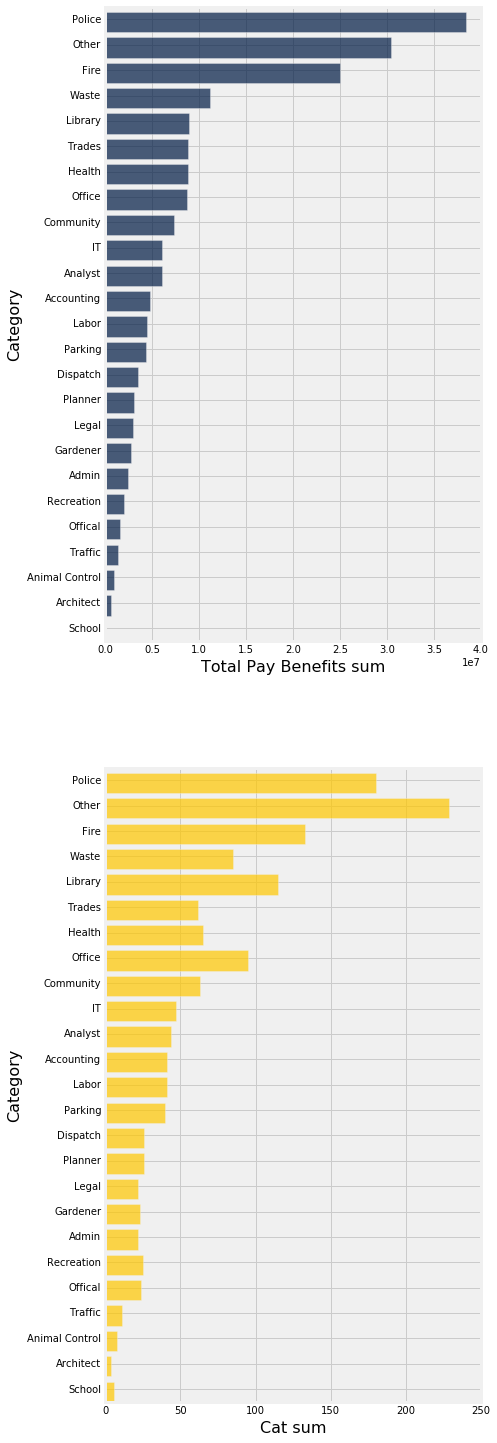

In [37]:
by_categories.sort('Total Pay Benefits sum', descending=True).barh('Category', select=['Total Pay Benefits sum', 'Cat sum'], overlay=False)

So let's try to understand the police category a bit more. 


In [38]:
police = job_categories.where('Category', 'Police')
police

Job Title,Base Pay,Overtime Pay,Other Pay,Total Benefits,Total Pay,Total Pay Benefits,Category,Cat
POLICE SERGEANT,"$132,540.85","$114,387.97","$53,483.56","$102,377.48","$300,412.38","$402,789.86",Police,1
POLICE LIEUTENANT,"$159,094.73","$38,995.01","$41,465.57","$124,819.29","$239,555.31","$364,374.60",Police,1
POLICE CHIEF,"$205,400.00",$0.00,"$7,380.00","$124,814.56","$212,780.00","$337,594.56",Police,1
POLICE CAPTAIN,"$182,382.48",$0.00,"$19,346.55","$133,848.06","$201,729.03","$335,577.09",Police,1
POLICE LIEUTENANT,"$159,094.73","$31,284.18","$20,132.52","$119,134.15","$210,511.43","$329,645.58",Police,1
POLICE CAPTAIN,"$182,382.48",$0.00,"$21,884.00","$121,365.25","$204,266.48","$325,631.73",Police,1
POLICE CAPTAIN,"$159,094.73","$7,668.11","$34,550.65","$123,852.11","$201,313.49","$325,165.60",Police,1
POLICE LIEUTENANT,"$159,094.73","$28,364.65","$19,671.10","$117,449.09","$207,130.48","$324,579.57",Police,1
POLICE LIEUTENANT,"$134,457.24","$36,225.22","$38,738.16","$111,729.65","$209,420.62","$321,150.27",Police,1
POLICE LIEUTENANT,"$159,094.73","$4,244.54","$26,276.73","$119,238.12","$189,616.00","$308,854.12",Police,1


How do the pay labels spread across the force?

We can look at histograms by pay label.  First all toegether and then broken apart.

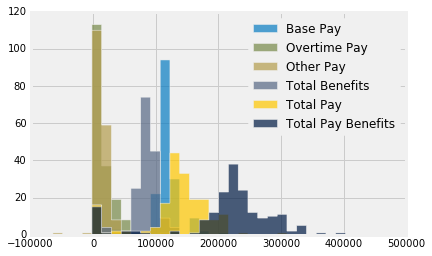

In [39]:
police.select(paylabels).hist(bins=30,normed=False)

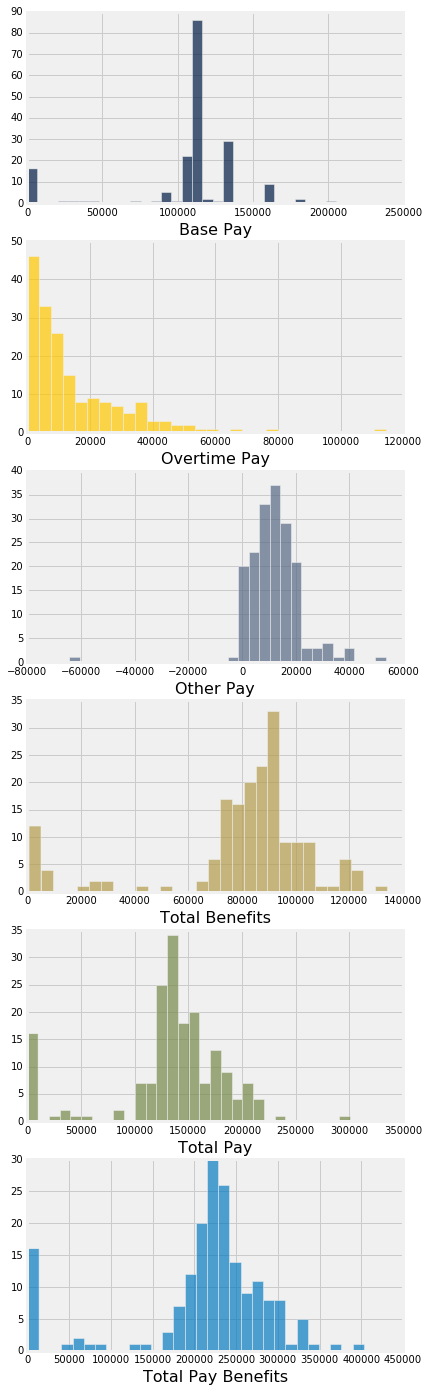

In [40]:
police.select(paylabels).hist(bins=30,normed=False, overlay=False)

Base pay seems to chunk into categories, perhaps by job title.  

Most members of the force do little overtime, but a few do a lot!

How many are in each Job Title?

In [41]:
police.group('Job Title')

Job Title,count
POLICE CAPTAIN,3
POLICE CHIEF,1
POLICE LIEUTENANT,10
POLICE OFFICER,131
POLICE REVIEW COMMISSION INVES,1
POLICE REVIEW COMMISSION OFFIC,1
POLICE SERGEANT,33


In [42]:
# We can actually get all the data by title
police.select(['Job Title','Base Pay', 'Overtime Pay']).group('Job Title', collect=lambda x:x)

Job Title,Base Pay,Overtime Pay
POLICE CAPTAIN,[ 182382.48 182382.48 159094.73],[ 0. 0. 7668.11]
POLICE CHIEF,[ 205400.],[ 0.]
POLICE LIEUTENANT,[ 159094.73 159094.73 159094.73 134457.24 159094.73 ...,[ 38995.01 31284.18 28364.65 36225.22 4244.54 103 ...
POLICE OFFICER,[ 114929.67 114929.67 114929.67 114929.67 114929.67 ...,[ 65218.2 78285.37 58174.37 45539.99 49006.25 5099 ...
POLICE REVIEW COMMISSION INVES,[ 87663.01],[ 0.]
POLICE REVIEW COMMISSION OFFIC,[ 0.],[ 0.]
POLICE SERGEANT,[ 132540.85 132540.85 132540.85 132540.85 136357.55 ...,[ 114387.97 39658.67 50117.44 41593.35 10401.66 ...


We can't just pivot by Job Title because we don't have a uniform number of rows, but what we can do is for pivot and bin (or histogram) so we can see the distribution of a column by job title.

Sure enough.  Officers cluster around 100-120k, sergeants at 130-140k, but there's a little overlap.

In [43]:
police.pivot_bin('Job Title', 'Base Pay', bins=np.arange(0,200000,10000)).show()

bin,POLICE CAPTAIN,POLICE CHIEF,POLICE LIEUTENANT,POLICE OFFICER,POLICE REVIEW COMMISSION INVES,POLICE REVIEW COMMISSION OFFIC,POLICE SERGEANT
0,0,0,0,15,0,1,0
10000,0,0,0,0,0,0,0
20000,0,0,0,1,0,0,0
30000,0,0,0,2,0,0,0
40000,0,0,0,1,0,0,0
50000,0,0,0,0,0,0,0
60000,0,0,0,0,0,0,0
70000,0,0,0,1,0,0,0
80000,0,0,0,0,1,0,0
90000,0,0,0,6,0,0,0


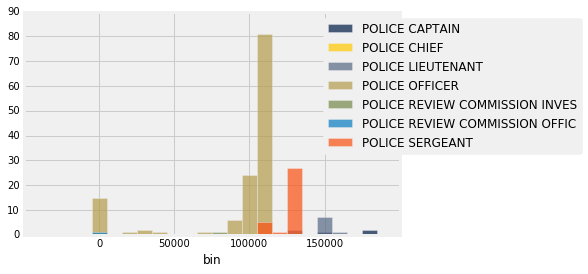

In [44]:
police.pivot_bin('Job Title', 'Base Pay', bins=np.arange(0,200000,10000)).bar('bin')

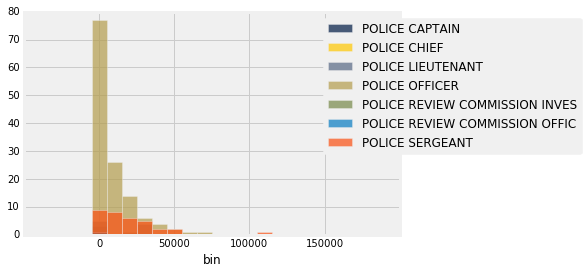

In [45]:
police.pivot_bin('Job Title', 'Overtime Pay', bins=np.arange(0,200000,10000)).bar('bin')

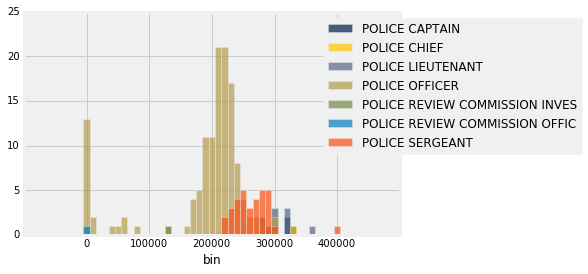

In [46]:
police.pivot_bin('Job Title', 'Total Pay Benefits', bins=np.arange(0,420000,10000)).bar('bin')

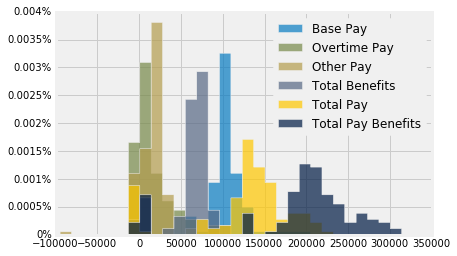

In [47]:
fire = job_categories.where('Category','Fire')
fire.select(paylabels).hist(bins=30)

In [48]:
fire.group('Job Title')

Job Title,count
ASSISTANT FIRE CHIEF,4
DEPUTY FIRE CHIEF,1
DEPUTY FIRE MARSHAL,1
FIRE AND LIFE-SAFETY PLANS EXA,1
FIRE APPARATUS OPERATOR,36
FIRE CAPTAIN,9
FIRE CHIEF,1
FIRE LIEUTENANT,24
FIRE PREVENTION INSPECTOR,2
FIREFIGHTER,54


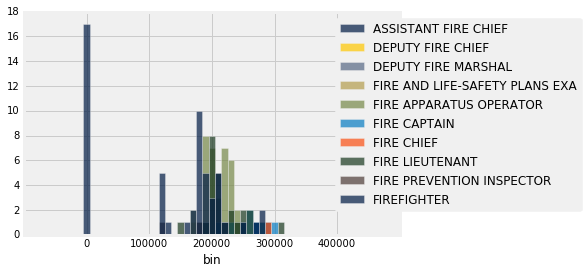

In [49]:
fire.pivot_bin('Job Title', 'Total Pay Benefits', bins=np.arange(0,420000,10000)).bar('bin')

Let's compare the 2011 data with more recent 2013 data.

In [50]:
raw_berkeley_sal_2013 = Table.read_table("./data/BerkeleyData/City_of_Berkeley_Employee_Salaries_-_2013.csv")
raw_berkeley_sal_2013

Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Notes,Agency
Romeo C Moscardon,ENGINEERING INSPECTOR,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,01/01/2013 12:00:00 AM,nan,Berkeley
Robert A Buell,MECHANICAL SWEEPER OPERATOR,$60082.90,$0.00,$-60046.57,$0.00,$36.33,$36.33,01/01/2013 12:00:00 AM,nan,Berkeley
Patricia Pitre',ASSISTANT RECREATION COORDINAT,$5221.20,$0.00,$-5164.41,$0.00,$56.79,$56.79,01/01/2013 12:00:00 AM,nan,Berkeley
Robert C Norwood,SKILLED LABORER,$61032.40,$0.00,$-60674.72,$111.81,$357.68,$469.49,01/01/2013 12:00:00 AM,nan,Berkeley
Jeremy M Alonzo,LIBRARY ASSISTANT,$779.56,$0.00,$280.20,$241.91,$1059.76,$1301.67,01/01/2013 12:00:00 AM,nan,Berkeley
Leticia S Murillo,OFFICE SPECIALIST II,$1692.42,$0.00,$-224.37,$0.00,$1468.05,$1468.05,01/01/2013 12:00:00 AM,nan,Berkeley
Martin Manqueros,FIRE APPARATUS OPERATOR,$62825.70,$0.00,$-62635.84,$1625.60,$189.86,$1815.46,01/01/2013 12:00:00 AM,nan,Berkeley
Kent R Murray,OFFICE SPECIALIST SUPERVISOR,$15282.55,$0.00,$-15008.94,$1606.08,$273.61,$1879.69,01/01/2013 12:00:00 AM,nan,Berkeley
Pete Gomez,POLICE OFFICER,$544.59,$0.00,$1328.69,$570.85,$1873.28,$2444.13,01/01/2013 12:00:00 AM,nan,Berkeley
Norma J Foster,COMMUNITY HLTH WRKR SPECIALIST,$0.00,$0.00,$3461.74,$0.00,$3461.74,$3461.74,01/01/2013 12:00:00 AM,nan,Berkeley


Well, the data base changed.  It picked up a few columns over the years. And we need to convert the salary strings to numbers so we can do analysis on them.  All in one go...

In [51]:
berkeley_sal_2013 = raw_berkeley_sal_2013.drop(['Year','Notes','Agency'])
berkeley_sal_2013

Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits
Romeo C Moscardon,ENGINEERING INSPECTOR,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
Robert A Buell,MECHANICAL SWEEPER OPERATOR,$60082.90,$0.00,$-60046.57,$0.00,$36.33,$36.33
Patricia Pitre',ASSISTANT RECREATION COORDINAT,$5221.20,$0.00,$-5164.41,$0.00,$56.79,$56.79
Robert C Norwood,SKILLED LABORER,$61032.40,$0.00,$-60674.72,$111.81,$357.68,$469.49
Jeremy M Alonzo,LIBRARY ASSISTANT,$779.56,$0.00,$280.20,$241.91,$1059.76,$1301.67
Leticia S Murillo,OFFICE SPECIALIST II,$1692.42,$0.00,$-224.37,$0.00,$1468.05,$1468.05
Martin Manqueros,FIRE APPARATUS OPERATOR,$62825.70,$0.00,$-62635.84,$1625.60,$189.86,$1815.46
Kent R Murray,OFFICE SPECIALIST SUPERVISOR,$15282.55,$0.00,$-15008.94,$1606.08,$273.61,$1879.69
Pete Gomez,POLICE OFFICER,$544.59,$0.00,$1328.69,$570.85,$1873.28,$2444.13
Norma J Foster,COMMUNITY HLTH WRKR SPECIALIST,$0.00,$0.00,$3461.74,$0.00,$3461.74,$3461.74


In [52]:
berkeley_sal_2013.set_format(berkeley_sal_2013.labels[2:], CurrencyFormatter)

Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits
Romeo C Moscardon,ENGINEERING INSPECTOR,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
Robert A Buell,MECHANICAL SWEEPER OPERATOR,"$60,082.90",$0.00,"$-60,046.57",$0.00,$36.33,$36.33
Patricia Pitre',ASSISTANT RECREATION COORDINAT,"$5,221.20",$0.00,"$-5,164.41",$0.00,$56.79,$56.79
Robert C Norwood,SKILLED LABORER,"$61,032.40",$0.00,"$-60,674.72",$111.81,$357.68,$469.49
Jeremy M Alonzo,LIBRARY ASSISTANT,$779.56,$0.00,$280.20,$241.91,"$1,059.76","$1,301.67"
Leticia S Murillo,OFFICE SPECIALIST II,"$1,692.42",$0.00,$-224.37,$0.00,"$1,468.05","$1,468.05"
Martin Manqueros,FIRE APPARATUS OPERATOR,"$62,825.70",$0.00,"$-62,635.84","$1,625.60",$189.86,"$1,815.46"
Kent R Murray,OFFICE SPECIALIST SUPERVISOR,"$15,282.55",$0.00,"$-15,008.94","$1,606.08",$273.61,"$1,879.69"
Pete Gomez,POLICE OFFICER,$544.59,$0.00,"$1,328.69",$570.85,"$1,873.28","$2,444.13"
Norma J Foster,COMMUNITY HLTH WRKR SPECIALIST,$0.00,$0.00,"$3,461.74",$0.00,"$3,461.74","$3,461.74"


In [53]:
berkeley_sal_2013["Total Pay & Benefits"]

array([  0.00000000e+00,   3.63300000e+01,   5.67900000e+01, ...,
         3.20466220e+05,   3.35633730e+05,   3.39017880e+05])

In [54]:
berkeley_sal_2013.sort('Total Pay & Benefits',descending=True)

Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits
David A Frankel,POLICE LIEUTENANT,"$159,939.00","$25,105.79","$53,355.02","$100,618.07","$238,399.81","$339,017.88"
Peter J Hong,POLICE SERGEANT,"$133,244.28","$77,554.04","$38,799.69","$86,035.72","$249,598.01","$335,633.73"
Andrew R Greenwood,POLICE CAPTAIN,"$183,350.44",$0.00,"$33,669.70","$103,446.08","$217,020.14","$320,466.22"
Michael K Meehan,POLICE CHIEF,"$205,400.00",$0.00,"$5,800.00","$105,435.68","$211,200.00","$316,635.68"
Erik M Upson,POLICE CAPTAIN,"$183,350.44",$0.00,"$28,921.43","$103,879.17","$212,271.87","$316,151.04"
Edward A Spiller,POLICE LIEUTENANT,"$159,939.00","$5,767.03","$45,103.22","$97,314.23","$210,809.25","$308,123.48"
Jennifer A Louis,POLICE SERGEANT,"$133,244.28","$43,337.74","$43,037.26","$87,121.74","$219,619.28","$306,741.02"
Randolph Files,POLICE LIEUTENANT,"$159,939.00","$27,566.38","$26,039.70","$91,512.60","$213,545.08","$305,057.68"
Cynthia Harris,POLICE CAPTAIN,"$183,350.44",$0.00,"$25,135.61","$93,382.23","$208,486.05","$301,868.28"
Christine S Daniel,CITY MANAGER,"$224,999.84",$0.00,$0.00,"$76,802.03","$224,999.84","$301,801.87"


Isn't that interesting.  They seem to have gotten their overtime under control.  Was that management, end of the occupy movement, something else?  Let's do a bit of comparison.

First we need to do some clean up and get labels we can deal with.

In [55]:
b2011 = berkeley_sal_2011.select(["Employee Name", "Job Title", "Total Pay Benefits"])
b2011.relabel('Total Pay Benefits', "Total 2011")
b2011.sort('Total 2011', descending=True)

Employee Name,Job Title,Total 2011
HOWARD H NONOGUCHI,POLICE SERGEANT,"$402,789.86"
DAVID A FRANKEL,POLICE LIEUTENANT,"$364,374.60"
MICHAEL K MEEHAN,POLICE CHIEF,"$337,594.56"
ERIK M UPSON,POLICE CAPTAIN,"$335,577.09"
KEVIN M SCHOFIELD,POLICE LIEUTENANT,"$329,645.58"
CYNTHIA HARRIS,POLICE CAPTAIN,"$325,631.73"
ANDREW R GREENWOOD,POLICE CAPTAIN,"$325,165.60"
RANDOLPH FILES,POLICE LIEUTENANT,"$324,579.57"
EDWARD A SPILLER,POLICE LIEUTENANT,"$321,150.27"
JOHN R TARASCIO,FIRE LIEUTENANT,"$314,247.70"


In [56]:
b2013 = berkeley_sal_2013.select(["Employee Name", "Job Title", "Total Pay & Benefits"])
b2013.relabel('Job Title','Title 2013')
b2013.relabel("Total Pay & Benefits", "Total 2013")
b2013.sort('Total 2013', descending=True)

Employee Name,Title 2013,Total 2013
David A Frankel,POLICE LIEUTENANT,"$339,017.88"
Peter J Hong,POLICE SERGEANT,"$335,633.73"
Andrew R Greenwood,POLICE CAPTAIN,"$320,466.22"
Michael K Meehan,POLICE CHIEF,"$316,635.68"
Erik M Upson,POLICE CAPTAIN,"$316,151.04"
Edward A Spiller,POLICE LIEUTENANT,"$308,123.48"
Jennifer A Louis,POLICE SERGEANT,"$306,741.02"
Randolph Files,POLICE LIEUTENANT,"$305,057.68"
Cynthia Harris,POLICE CAPTAIN,"$301,868.28"
Christine S Daniel,CITY MANAGER,"$301,801.87"


Snap! They decided that case was a good idea for proper nouns.  Let's go back to the old way.

In [57]:
b2013['Employee Name'] = b2013.apply(str.upper, 'Employee Name')
b2013

Employee Name,Title 2013,Total 2013
ROMEO C MOSCARDON,ENGINEERING INSPECTOR,$0.00
ROBERT A BUELL,MECHANICAL SWEEPER OPERATOR,$36.33
PATRICIA PITRE',ASSISTANT RECREATION COORDINAT,$56.79
ROBERT C NORWOOD,SKILLED LABORER,$469.49
JEREMY M ALONZO,LIBRARY ASSISTANT,"$1,301.67"
LETICIA S MURILLO,OFFICE SPECIALIST II,"$1,468.05"
MARTIN MANQUEROS,FIRE APPARATUS OPERATOR,"$1,815.46"
KENT R MURRAY,OFFICE SPECIALIST SUPERVISOR,"$1,879.69"
PETE GOMEZ,POLICE OFFICER,"$2,444.13"
NORMA J FOSTER,COMMUNITY HLTH WRKR SPECIALIST,"$3,461.74"


Now we can put the two tables together to see what happened with employees who were around in both years.  Here we get to use another powerful operations on tables.

* `Table.join`: joins two tables together using a column of each that contains common values.

Here we have the employee names in each table.  The join will give us the title and salary in both years for those employees in both tables, i.e., working for the city in both years

In [58]:
b11_13 = b2011.join('Employee Name', b2013)
b11_13

Employee Name,Job Title,Total 2011,Title 2013,Total 2013
AARON E SAGE,SENIOR PLANNER,153752,SENIOR PLANNER,158669
AARON M LEE,ASSISTANT FIRE CHIEF,291049,DEPUTY FIRE CHIEF,245273
AARON P DIEKEN,TRAFFIC MAINT WKR I,108753,TRAFFIC MAINT WKR I,99871.6
AARON R BAKER,BUILDING MAINTENANCE MECHANIC,115985,BUILDING MAINTENANCE SUPERVISO,106721
AARON T LOWE,CUST SERVS SPEC III,88239.9,CUST SERVS SPEC III,92845
ABDUL WAYNE,RECREATION ACTIVITY LEADER,50784.1,RECREATION ACTIVITY LEADER,50320.4
ABIGAIL T GREGOR,PSYCH SOC WKR II,114602,PSYCH SOC WKR II,110186
ABRAHAM ROMAN,ASSISTANT FIRE CHIEF,282085,ASSISTANT FIRE CHIEF,242650
ABRAXAS K SEALE,OFFICE SPECIALIST III,102195,OFFICE SPECIALIST III,102207
ADADU YEMANE,ASSOCIATE CIVIL ENGINEER,187277,ASSOCIATE CIVIL ENGINEER,178986


Let's add a column with increase in total pay.

In [59]:
b11_13["Increase"] =b11_13['Total 2013'] - b11_13['Total 2011']

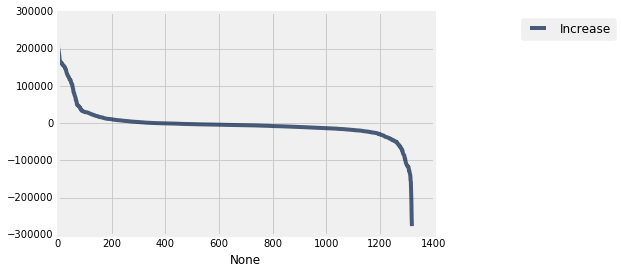

In [60]:
b11_13.sort('Increase', "decr").select('Increase').plot()

On the tails we have people who joined part way through 2011 or left part way through 2013.

In [61]:
b11_13.stats(summary_ops)

statistic,Employee Name,Job Title,Total 2011,Title 2013,Total 2013,Increase
min,AARON E SAGE,ACCOUNTANT I,0,ACCOUNTANT I,0,-276596
firstQtile,,,100220,,97441.9,-12927.5
median,,,128828,,125980,-4898.45
mean,,,136065,,134084,-1981.19
thirdQtile,,,100220,,97441.9,-12927.5
max,ZOE A PEIRCE,WORKERS' COMPENSATION ANALYST,364375,WORKERS' COMPENSATION ANALYST,339018,251371


Well that's interesting.  Total compensation seems to have dropped.  Did the budget actually go down?

In [62]:
sum2011 = np.sum(berkeley_sal_2011['Total Pay Benefits'])
"${:,}".format(int(sum2011))

'$194,576,175'

In [63]:
sum2013 = np.sum(berkeley_sal_2013['Total Pay & Benefits'])
"${:,}".format(int(sum2013))

'$181,102,667'

In [64]:
"${:,}".format(int(sum2013-sum2011))

'$-13,473,508'

In [65]:
"{:.1%}".format((sum2013-sum2011)/sum2011)

'-6.9%'

Look at that.

In [66]:
np.sum(berkeley_sal_2011['Overtime Pay'])

8075636.5499999998

In [67]:
np.sum(berkeley_sal_2013['Overtime Pay'])

8444424.5299999993

Let's see who got promoted or demoted

In [68]:
b11_13.where(b11_13['Job Title'] != b11_13['Title 2013']).sort('Total 2013', descending=True).show()

Employee Name,Job Title,Total 2011,Title 2013,Total 2013,Increase
AVERY L WEBB,BATTALION CHIEF,262363,DEPUTY FIRE CHIEF,285924,23561.1
GILBERT K DONG,DEPUTY FIRE CHIEF,288721,FIRE CHIEF,276889,-11831.1
PAUL A CAVAGNARO,FIRE CAPTAIN,235611,BATTALION CHIEF,261926,26314.8
AARON M LEE,ASSISTANT FIRE CHIEF,291049,DEPUTY FIRE CHIEF,245273,-45776
FREDERICK S FERRIS,RECREATION & YOUTH SVCS MANAGE,190546,DIRECTOR OF PRKS/RECREATION/WF,216606,26060.3
PEGGY J GIBBONS,DEPUTY DIRECTOR OF HEALTH,218221,DEPUTY DIRECTOR OF PRKS/REC/WF,211818,-6403.77
MATTHEW W EINSPAHR,FIREFIGHTER,173599,FIRE APPARATUS OPERATOR,169536,-4063.1
DAVID A LOPEZ,SENIOR BUILDING PLANS EXAMINER,1174.27,ASSIST BUILDING & SAFETY MGR,157577,156402
ROLANDO C VILLAREAL,SENIOR ENVIRONMENTAL HEALTH SP,149484,ENVIRONMENTAL HEALTH SUPERVISO,150115,631.47
DENISE L BROWN,RECREATION PROGRAM SUPERVISOR,130432,RECREATION & YOUTH SVCS MANAGE,149925,19492.6


In [69]:
b11_13.where(b11_13['Job Title'] == b11_13['Title 2013']).sort('Increase', descending=True).show()

Employee Name,Job Title,Total 2011,Title 2013,Total 2013,Increase
ERIC A ANGSTADT,DIRECTOR OF PLANNING,3048.89,DIRECTOR OF PLANNING,254419,251371
PHILLIP L HARRINGTON,DEPUTY DIRECTOR OF PUBLIC WORK,2802.78,DEPUTY DIRECTOR OF PUBLIC WORK,205655,202853
TIMOTHY GARDNER,POLICE OFFICER,5599.34,POLICE OFFICER,204043,198443
MATTHEW J VALLE,POLICE OFFICER,3692.92,POLICE OFFICER,199297,195604
CHRISTOPHER M SCOTT,POLICE OFFICER,5623.11,POLICE OFFICER,193510,187887
PAUL J TILLBERG,POLICE OFFICER,1547.85,POLICE OFFICER,186427,184879
MICHAEL V STEFANAC,FIREFIGHTER,604,FIREFIGHTER,177802,177198
MICHAEL R DRAGOVICH,FIREFIGHTER,2652.51,FIREFIGHTER,173269,170616
DEJUAN M TURNER,FIREFIGHTER,2825.54,FIREFIGHTER,170019,167193
C ESSEX Q COMBONG,POLICE OFFICER,1515.6,POLICE OFFICER,167087,165572


Perhaps we might want to look at the relationship of these two variables.  That leads to another useful operator

* `Table.scatter`: does a scatter plot of columns against one columns



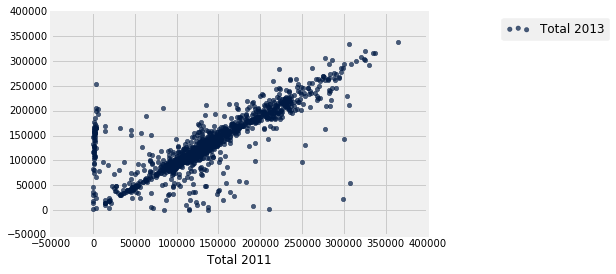

In [70]:
b11_13.scatter('Total 2011', 'Total 2013')

## Summary


This notebook has provided a introduction to many of the concepts and features in datascience tables in the context of a fairly complete example on open public data.

* Creating tables: `Table.read_table` - reads a file or url into a Table.  It is primarily used for csv files.  Tables can also be created from local data structures by constructing a tables with `Table()` and filling it using `with_columns` or `with_rows`.
* Accessing columns, rows, and elements of table.
* Cleaning up raw tables and setting formatters for table displays.
* Getting descriptive statistics with `stats` to sumarize the columns in a table.
* Working with portions of a table using `select` to select columns `where` to filter rows, `drop` to select all but the specified columns.
* Visualizing data with `hist`, `plot`, `barh`, `bar`, and `scatter`.
* Sorting tables with `sort` using columns as keys.
* Grouping entries in tables using `group`, where groups are defined by rows with common values in a specified collection of columns; the values in the remaining columns are then aggregated using a collection function.  The identity collector all all the values in a group to be collected into a list.
* Applying functions to all the elements of a column of a table, using `apply`
* Distributing columns of a table using `pivot_bin` where each unique set of values in a specified collection of columns serves as a "key" which is a column name in the result.  Values in the remaining columns are binned to produce the rows in the result.  This is used when the number of entries for each key varies.  Where there is a single value for each key, `pivot` can be used.

